__Kaggle competition - Titanic survivorship__

1. [Import](#Import)
    1. [Tools](#Tools)
    1. [Data](#Data)    
1. [EDA](#EDA)
    1. [Category feature EDA](#category-feature-EDA)
    1. [Count feature EDA](#Count-feature-EDA)
    1. [Continuous feature EDA](#Continuous-feature-EDA)
    1. [Faceting](#Faceting)
    1. [Target variable evaluation](#Target-variable-evaluation)    
1. [Data preparation](#Data-preparation)
    1. [Missing data](#Missing-data)
    1. [Feature engineering](#Feature-engineering)
        1. [Handcrafted](#Handcrafted)
        1. [Polynomial features](#Polynomial-features)
        1. [Encoding](#Encoding)
    1. [Feature transformation](#Feature-transformation)
        1. [Skew correction](#Skew-correction)
        1. [Scaling](#Scaling)     
    1. [Outliers](#Outliers)
    1. [Additional exploratory data analysis](#Additional-exploratory-data-analysis)
1. [Feature selection](#Feature-selection)    
1. [Modeling](#Modeling)
    1. [Data preparation](#Data-preparation-1)
    1. [Bayesian hyper-parameter optimization](#Bayesian-hyper-parameter-optimization)
    1. [Model performance evaluation - standard models](#Model-performance-evaluation-standard-models)
    1. [Model explanability](#Model-explanability)
    1. [Submission - standard models](#Submission-standard-models)
1. [Stacking](#Stacking)
    1. [Primary models](#Primary-models)
    1. [Meta model](#Meta-model)                
    1. [Model performance evaluation - stacked models](#Model-performance-evaluation-stacked-models)
    1. [Submission - stacked models](#Submission-stacked-models)    

# Import

<a id = 'Import'></a>

## Tools

<a id = 'Tools'></a>

In [1]:
# standard libary and settings
import copy
import os
import sys
import importlib
import itertools
from functools import reduce
import time; rundate = time.strftime("%Y%m%d")

import warnings
warnings.simplefilter("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np
np.set_printoptions(threshold=np.inf, suppress=True)

import pandas as pd
pd.set_option("display.max_rows", 500); pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.datasets as datasets
import sklearn.ensemble as ensemble
import sklearn.impute as impute
import sklearn.linear_model as linear_model
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import category_encoders as ce

import lightgbm
import xgboost

from hyperopt import hp

import eif
import shap
shap.initjs()

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import squarify

%matplotlib inline

try:
    #     import mlmachine as mlm
    #     from prettierplot.plotter import PrettierPlot
    #     import prettierplot.style as style
    import asdfasd
except ModuleNotFoundError:
    sys.path.append(
        "../../../mlmachine"
    ) if "../../../../mlmachine" not in sys.path else None
    sys.path.append(
        "../../../prettierplot"
    ) if "../../../../prettierplot" not in sys.path else None

    import mlmachine as mlm
    import mlmachine.data as data
    from mlmachine.features.preprocessing import (
        DataFrameSelector,
        PandasPipeline,
        KFoldSelectEncoder,
        ContextImputer,
        PandasFeatureUnion,
        DualTransformer,
    )
    from prettierplot.plotter import PrettierPlot
    import prettierplot.style as style
else:
    print(
        "This notebook relies on the libraries mlmachine and prettierplot. Please run:"
    )
    print("\tpip install mlmachine")
    print("\tpip install prettierplot")

## Data

<a id = 'Data'></a>

In [ ]:
# load data and print dimensions
df_train, df_valid = data.titanic()

print("Training data dimensions: {}".format(df_train.shape))
print("Validation data dimensions: {}".format(df_valid.shape))

In [ ]:
# display info and first 5 rows
df_train.info()
display(df_train[:5])

In [ ]:
# review counts of different column types
df_train.dtypes.value_counts()

In [ ]:
# Load training data into mlmachine
ordinal_encodings = {
        "Pclass": [1, 2, 3], # Pclass
    }

train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId", "Ticket"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Cabin","Embarked","Name"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = ordinal_encodings,
    target_type="category",
)

In [ ]:
# load training data into mlmachine
valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId", "Ticket"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Cabin","Embarked","Name"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = ordinal_encodings,    
)

# EDA

<a id = 'EDA'></a>

## Category feature EDA

<a id = 'category-feature-EDA'></a>

In [ ]:
# number features
for feature in train.data.mlm_dtypes["category"]:
    train.eda_cat_target_cat_feat(
        feature=feature,
        level_count_cap=10,
        legend_labels=["Died","Survived"],
        chart_scale=15
    )

## Count feature EDA

<a id = 'Count-feature-EDA'></a>

In [ ]:
# number features
for feature in train.data.mlm_dtypes["count"]:
    train.eda_cat_target_cat_feat(
        feature=feature,
        level_count_cap=10,
        legend_labels=["Died","Survived"],
        chart_scale=15
    )

## Continuous feature EDA

<a id = 'Continuous-feature-EDA'></a>

In [ ]:
# continuous features
for feature in train.data.mlm_dtypes["continuous"]:
    train.eda_cat_target_num_feat(
        feature=feature,
        outliers_out_of_scope=5,
        legend_labels=["Died","Survived"],
        chart_scale=12
    )

##### Correlation

In [ ]:
# correlation heat map
p = PrettierPlot()
ax = p.make_canvas()
p.corr_heatmap(
    df=train.recombine_data(),
#     df=train.data,
    annot=True,
    ax=ax,
)

In [ ]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall',chart_scale=10)
ax = p.make_canvas()
p.corr_heatmap_target(
    df=train.data,
    target=train.target,
    thresh=0.01,
    annot=True,
    ax=ax,
)

In [ ]:
# pair plot
p = PrettierPlot(chart_scale=15)
p.pair_plot(
    df=train.data[["Age","Fare"]],
    target=train.target,
    diag_kind="auto",
    legend_labels=["Died","Survived"],
)

## Faceting

<a id = 'Faceting'></a>

In [ ]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_scale=12)
ax = p.make_canvas(title="Survivorship, embark location by passenger class", y_shift=0.7)
p.facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Embarked",
    y=train.target.name,
    split="Pclass",
    y_units="ff",
    ax=ax,
)

In [ ]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_scale=12)
ax = p.make_canvas(title="Survivorship, passenger class by gender", y_shift=0.7)
p.facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Pclass",
    y=train.target.name,
    split="Sex",
    y_units="ff",
    ax=ax,
)

In [ ]:
# facet Pclass vs Embarked
p = PrettierPlot(chart_scale=12)
ax = p.make_canvas(title="Survivorship,embark location by gender", y_shift=0.7)
p.facet_two_cat_bar(
    df=train.recombine_data(train.data, train.target),
    x="Embarked",
    y=train.target.name,
    split="Sex",
    y_units="ff",
    ax=ax,
)

In [ ]:
#
p = PrettierPlot()
p.facet_two_cat_point(
    df=train.recombine_data(train.data, train.target),
    x="Sex",
    y=train.target.name,
    split="Pclass",
    cat_col="Embarked",
    aspect=1.0,
    height=5,
    bbox=(1.3, 1.2),
    legend_labels=["1st class", "2nd class", "3rd class"],
)

In [ ]:
#
p = PrettierPlot()
p.facet_two_cat_point(
    df=train.recombine_data(train.data, train.target).dropna(subset=["Embarked"]),
    x="Embarked",
    y=train.target.name,
    split="Pclass",
    cat_col="Sex",
    aspect=1.0,
    height=5,
    bbox=(1.5, 0.8),
    legend_labels=["1st class", "2nd class", "3rd class"],
)

In [ ]:
#
p = PrettierPlot()
p.facet_cat_num_hist(
    df=train.recombine_data(train.data, train.target),
    split=train.target.name,
    legend_labels=["Died", "Lived"],
    cat_row="Sex",
    cat_col="Embarked",
    num_col="Age",
    bbox=(1.9, 1.0),
    height=4,
    aspect=1,
)

In [ ]:
#
p = PrettierPlot(chart_scale=15)
p.facet_cat_num_scatter(
    df=train.recombine_data(train.data, train.target),
    split=train.target.name,
    legend_labels=["Died", "Lived"],
    cat_row="Sex",
    cat_col="Embarked",
    x="Fare",
    y="Age",
    bbox=(1.9, 1.0),
    height=4,
    aspect=1,
)

## Target variable evaluation

<a id = 'Target-variable-evaluation'></a>

In [ ]:
# null score
pd.Series(train.target).value_counts(normalize=True)

# Data preparation

<a id = 'Data-preparation'></a>

## Missing data


<a id = 'Missing-data'></a>

##### Training

In [ ]:
# evaluate missing data
train.eda_missing_summary()

In [ ]:
# missingno matrix
msno.matrix(train.data)

In [ ]:
# missingno bar
msno.bar(train.data)

In [ ]:
# missingno heatmap
msno.heatmap(train.data)

In [ ]:
# missingno dendrogram
msno.dendrogram(train.data)

##### Validation

In [ ]:
# evaluate missing data
valid.eda_missing_summary()

In [ ]:
# missingno matrix
msno.matrix(valid.data)

In [ ]:
# missingno bar
msno.bar(valid.data)

In [ ]:
# missingno heatmap
msno.heatmap(valid.data)

In [ ]:
# missingno dendrogram
msno.dendrogram(valid.data)

##### Training vs. validation


In [ ]:
# compare feature with missing data
train.missing_col_compare(train=train.data, validation=valid.data)

##### Impute

In [ ]:
train.data.info()

In [ ]:
# impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Age","Pclass"]),
        ContextImputer(null_col="Age", context_col="Pclass", strategy="mean")
    )),
    ("fare", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        ContextImputer(null_col="Fare", context_col="Pclass")
    )),
    ("embarked", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasPipeline(impute.SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Cabin"]),
        PandasPipeline(impute.SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked","Cabin"])
    )),
])

train.data = impute_pipe.fit_transform(train.data)
valid.data = impute_pipe.transform(valid.data)

In [ ]:
train.eda_missing_summary()

In [ ]:
valid.eda_missing_summary()

## Feature engineering

<a id = 'Feature-engineering'></a>

### Handcrafted

<a id = 'Handcrafted'></a>

In [ ]:
### training data
# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in train.data["Name"]]
train.data["Title"] = pd.Series(
    title,
    index=train.data.index,
    dtype="object",
)
train.data["Title"] = train.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
train.data["Title"] = train.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
train.data["Title"] = train.data["Title"].astype("category")

# distill cabin feature
train.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in train.data["Cabin"]],
    index=train.data.index,
    dtype="category",
)

# family size features and binning
train.data["FamilySize"] = train.data["SibSp"] + train.data["Parch"] + 1
train.data["FamilySize"] = train.data["FamilySize"].astype("int64")

In [ ]:
### validation data
# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in valid.data["Name"]]
valid.data["Title"] = pd.Series(
    title,
    index=valid.data.index,
    dtype="object",
)
valid.data["Title"] = valid.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
valid.data["Title"] = valid.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
valid.data["Title"] = valid.data["Title"].astype("category")

# distill cabin feature
valid.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in valid.data["Cabin"]],
    index=valid.data.index,
    dtype="category",
)

# additional features
valid.data["FamilySize"] = valid.data["SibSp"] + valid.data["Parch"] + 1
valid.data["FamilySize"] = valid.data["FamilySize"].astype("int64")

### Polynomial features

<a id = 'Polynomial-features'></a>

In [ ]:
# transform pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasPipeline(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"], exclude_columns=["Name","Cabin"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

### Encoding

<a id = 'Encoding'></a>

##### Evaluate

In [ ]:
### training data
# counts of unique values in training data string columns
train.data[train.data.mlm_dtypes["category"]].apply(pd.Series.nunique, axis=0)

In [ ]:
### training data
# print unique values in each category columns
for col in train.data.mlm_dtypes["category"]:
    print(col, np.unique(train.data[col]))

In [ ]:
### validation data
# counts of unique values in validation data string columns
valid.data[valid.data.mlm_dtypes["category"]].apply(pd.Series.nunique, axis=0)

In [ ]:
### validation data
# print unique values in each category columns
for col in valid.data.mlm_dtypes["category"]:
    print(col, np.unique(valid.data[col]))

In [ ]:
# identify values that are present in the training data but not the validation data, and vice versa
for col in train.data.mlm_dtypes["category"]:
    train_values = train.data[col].unique()
    valid_values = valid.data[col].unique()

    train_diff = set(train_values) - set(valid_values)
    valid_diff = set(valid_values) - set(train_values)

    if len(train_diff) > 0 or len(valid_diff) > 0:
        print("\n\n*** " + col)
        print("Value present in training data, not in validation data")
        print(train_diff)
        print("Value present in validation data, not in training data")
        print(valid_diff)

##### Encode

In [ ]:
# encode pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", pipeline.make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["nominal"]),
        PandasPipeline(preprocessing.OneHotEncoder(drop="first")),
    )),
    ("ordinal", pipeline.make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasPipeline(preprocessing.OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", pipeline.make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["continuous"]),
        PandasPipeline(preprocessing.KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_columns=train.data.mlm_dtypes["nominal"] + list(ordinal_encodings.keys())),
    )),
])

train.data = encode_pipe.fit_transform(train.data)
valid.data = encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

In [ ]:
# target encoding pipe
target_encode_pipe = PandasFeatureUnion([
    ("target", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=ce.TargetEncoder,
        ),
    )),
    ("woe", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=ce.WOEEncoder,
        ),
    )),
    ("catboost", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=ce.CatBoostEncoder,
        ),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

train.data = target_encode_pipe.fit_transform(train.data)
valid.data = target_encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

## Feature transformation

<a id = 'Feature-transformation'></a>

### Skew correction

<a id = 'Skew-correction'></a>

In [ ]:
### training data
# evaluate skew of number features
train.skew_summary()

In [ ]:
### validation data
# evaluate skew of number features
valid.skew_summary()

In [ ]:
# skew correction pipeline
skew_pipe = PandasFeatureUnion([
    ("skew", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        DualTransformer(),
    )),    
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"]),
    )),
])

# train.data = skew_pipe.fit_transform(train.data)
# valid.data = skew_pipe.transform(valid.data)

# train.update_dtypes()
# valid.update_dtypes()

### Scaling

<a id = 'Scaling'></a>

In [ ]:
#
scale_pipe = PandasFeatureUnion([
    ("scale", pipeline.make_pipeline(
        DataFrameSelector(),
        PandasPipeline(preprocessing.RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

## Outliers


<a id = 'Outliers'></a>

In [ ]:
# identify outliers using IQR
train_pipe = pipeline.Pipeline([
    ("outlier",train.OutlierIQR(
                outlier_count=10,
                iqr_step=1.5,
                features=train.data.mlm_dtypes["continuous"],
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
iqr_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers))
print(iqr_outliers)

In [ ]:
# identify outliers using Isolation Forest
clf = ensemble.IsolationForest(
    behaviour="new",
    max_samples=train.data.shape[0],
    random_state=0,
    contamination=0.01,
)
clf.fit(train.data[train.data.columns])
preds = clf.predict(train.data[train.data.columns])

# evaluate index values
mask = np.isin(preds, -1)
if_outliers = np.array(train.data[mask].index)
print(if_outliers)

In [ ]:
# identify outliers using extended isolation forest
train_pipe = pipeline.Pipeline([
    ("outlier",train.ExtendedIsoForest(
                columns=train.data.mlm_dtypes["continuous"],
                n_trees=100,
                sample_size=256,
                extension_level=1,
                anomalies_ratio=0.03,
                drop_outliers=False,))
    ])
train.data = train_pipe.transform(train.data)

# capture outliers
eif_outliers = np.array(sorted(train_pipe.named_steps["outlier"].outliers))
print(eif_outliers)

In [ ]:
# identify outliers that are identified in multiple algorithms
outliers = reduce(np.intersect1d, (iqr_outliers, if_outliers, eif_outliers))
# outliers = reduce(np.intersect1d, (if_outliers, eif_outliers))
print(outliers)

In [ ]:
# review outlier identification summary
outlier_summary = train.outlier_summary(iqr_outliers=iqr_outliers,
                             if_outliers=if_outliers,
                             eif_outliers=eif_outliers
                            )
outlier_summary[outlier_summary["count"] >= 3]

In [ ]:
# remove outlers from predictors and response
outliers = np.array([258, 305, 438, 679, 737, 745])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

## Additional exploratory data analysis

<a id = 'Additional-exploratory-data-analysis'></a>

In [ ]:
# correlation heat map with most highly correlated features relative to the target
p = PrettierPlot(plot_orientation='tall',chart_scale=15)
ax = p.make_canvas()
p.corr_heatmap_target(
    df=train.data,
    target=train.target,
    thresh=0.3,
    annot=True,
    ax=ax,
)

In [ ]:
# correlation heat map
p = PrettierPlot(chart_scale=25)
ax = p.make_canvas()
p.corr_heatmap(df=train.data, annot=False, ax=ax)

# Feature selection

<a id = 'Feature-selection'></a>

In [4]:
# generate feature importance summary
estimators = [
    lightgbm.LGBMClassifier,
    ensemble.RandomForestClassifier,
    ensemble.GradientBoostingClassifier,
    ensemble.ExtraTreesClassifier,
    ensemble.AdaBoostClassifier,
    xgboost.XGBClassifier,
]

fs = train.FeatureSelector(
    data=train.data,
    target=train.target,
    estimators=estimators,
)
feature_selector_summary = fs.feature_selector_suite(
    save_to_csv=True,
    n_jobs=5,
)

In [5]:
# calculate cross-validation performance
estimators = [
    svm.SVC,
    lightgbm.LGBMClassifier,
    linear_model.LogisticRegression,
    xgboost.XGBClassifier,
    ensemble.RandomForestClassifier,
    ensemble.GradientBoostingClassifier,
    ensemble.AdaBoostClassifier,
    ensemble.ExtraTreesClassifier,
    neighbors.KNeighborsClassifier,
]

cv_summary = fs.feature_selector_cross_val(
    feature_selector_summary=feature_selector_summary,
#     feature_selector_summary = pd.read_csv("feature_selection_summary_2001291333.csv", index_col=0),
    estimators=estimators,
    scoring=["accuracy"],
    n_folds=5,
    step=1,
    n_jobs=5,
    save_to_csv=True,
)

###### Accuracy

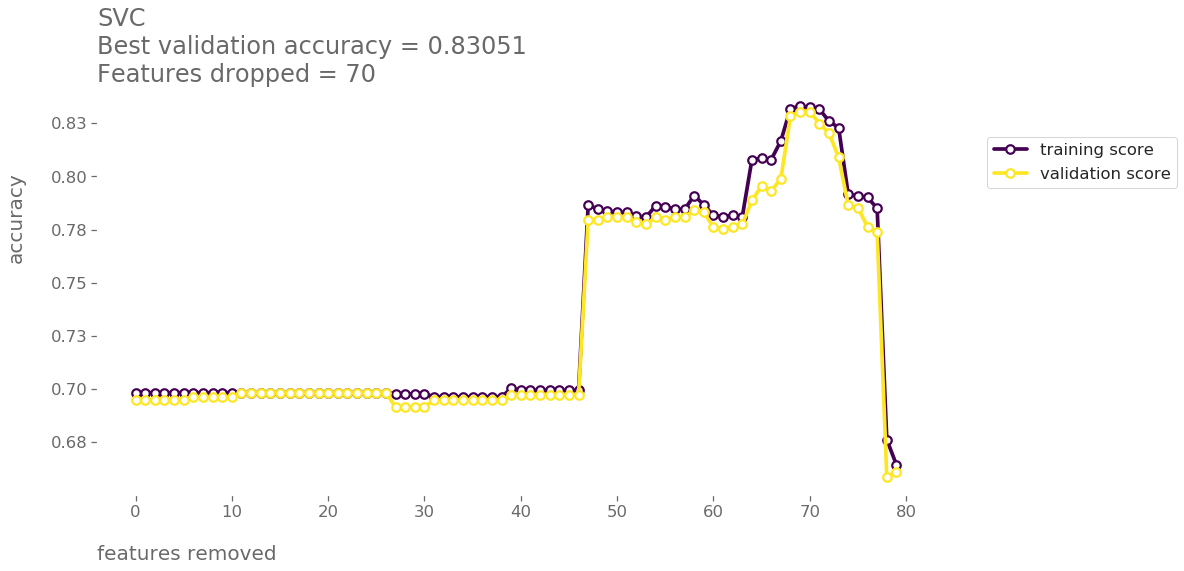

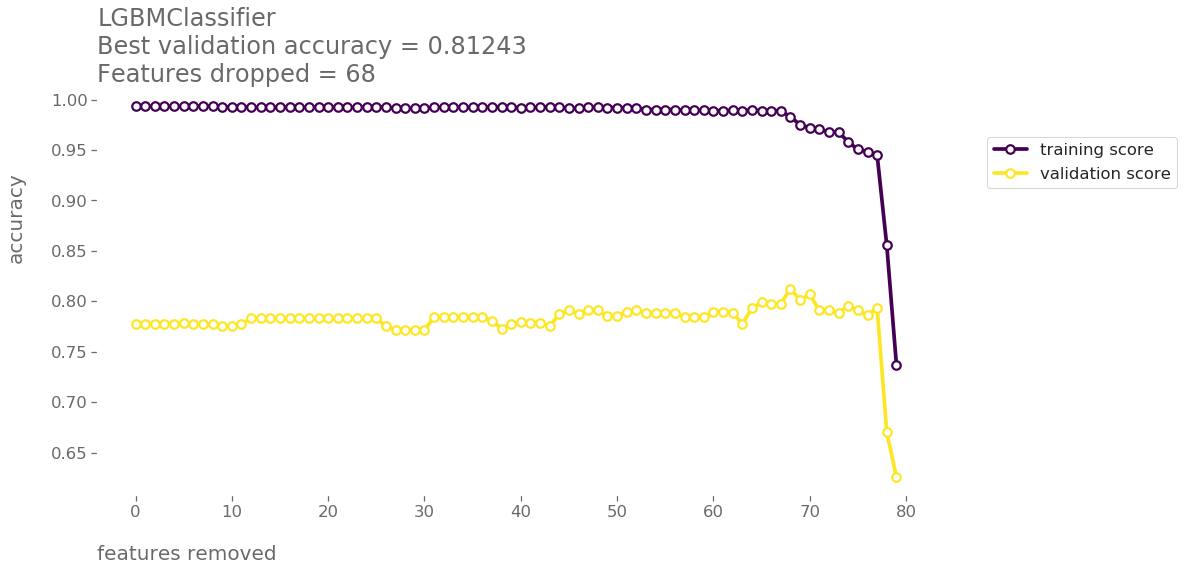

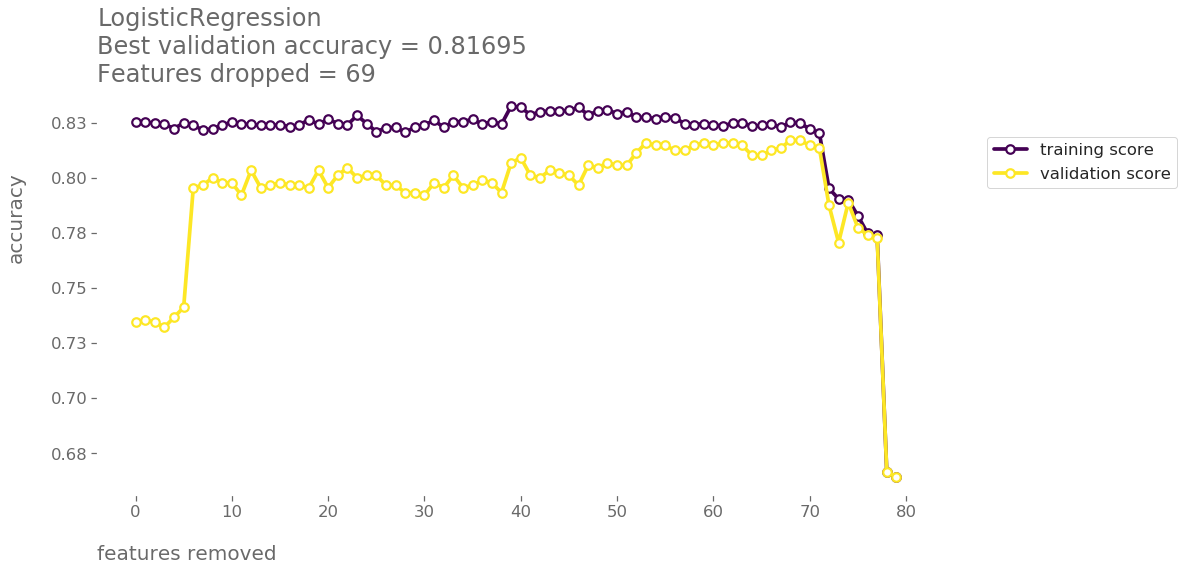

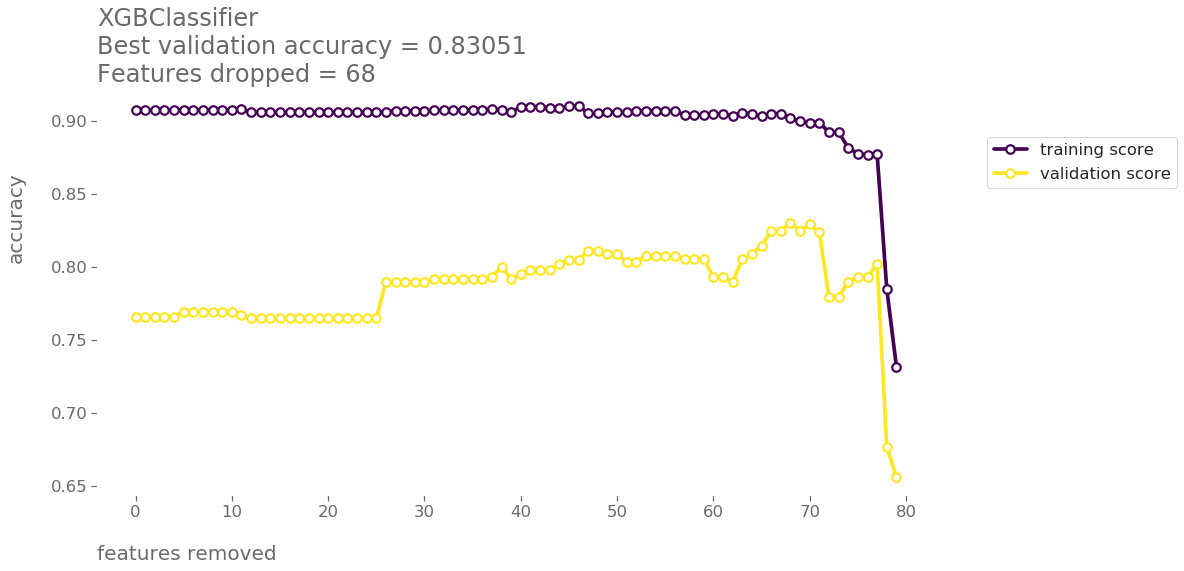

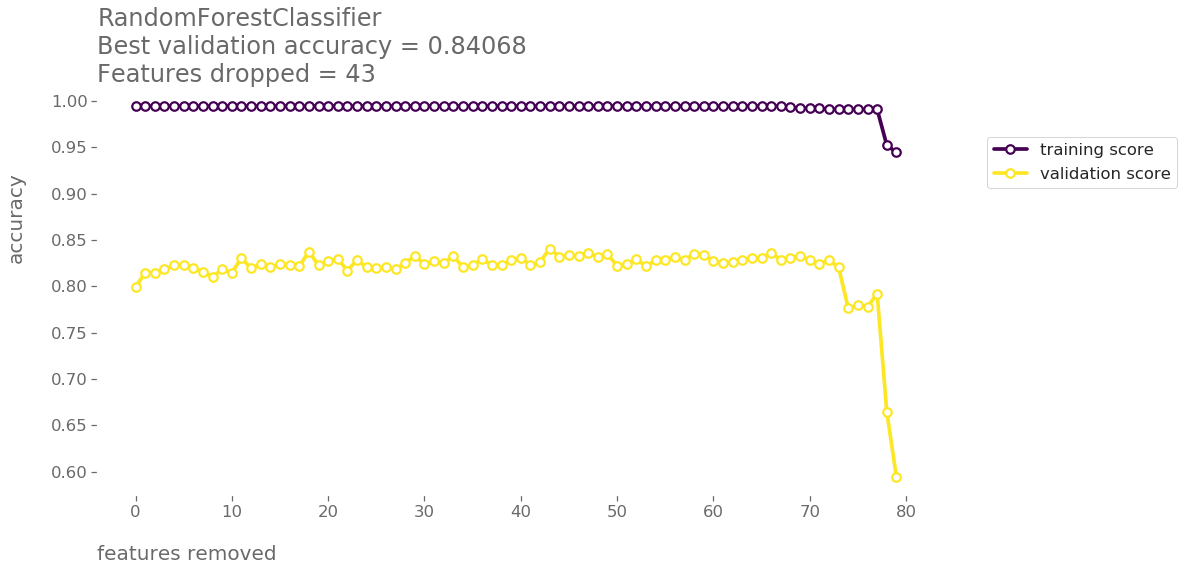

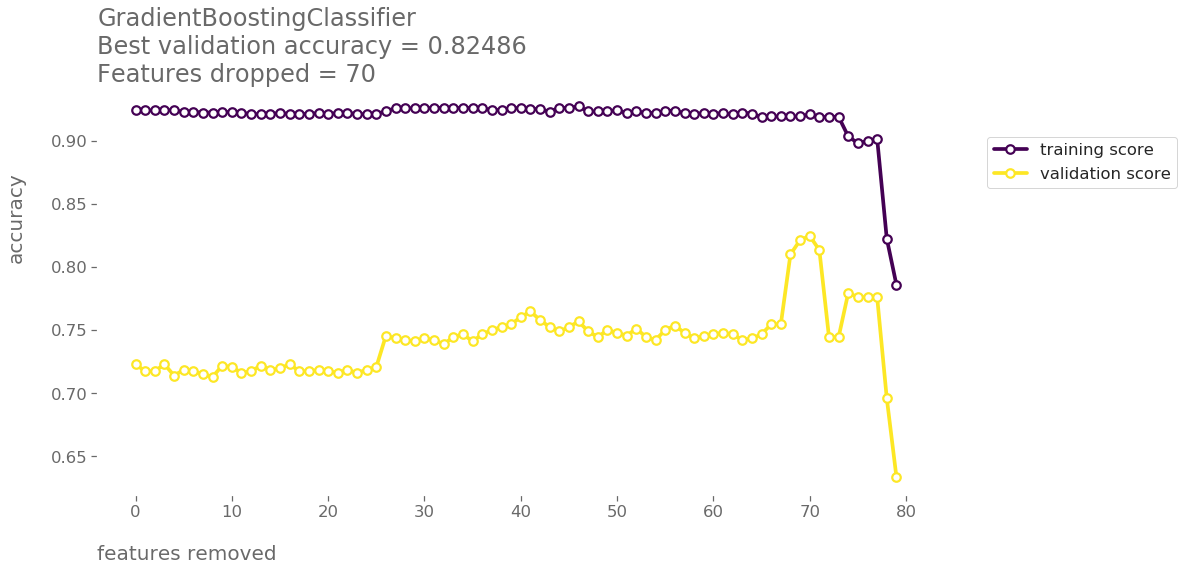

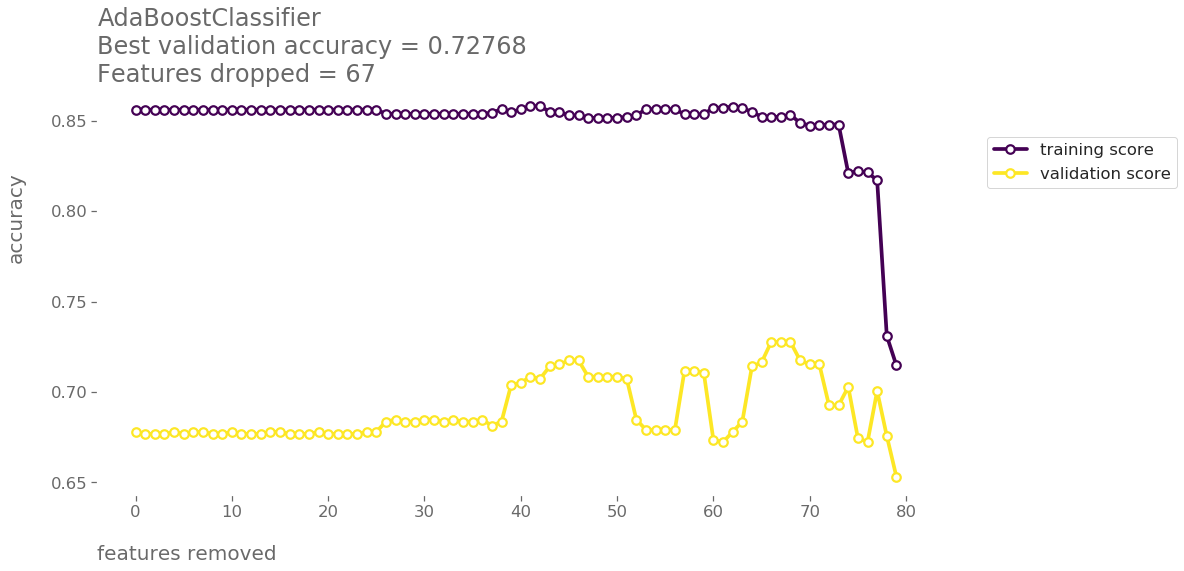

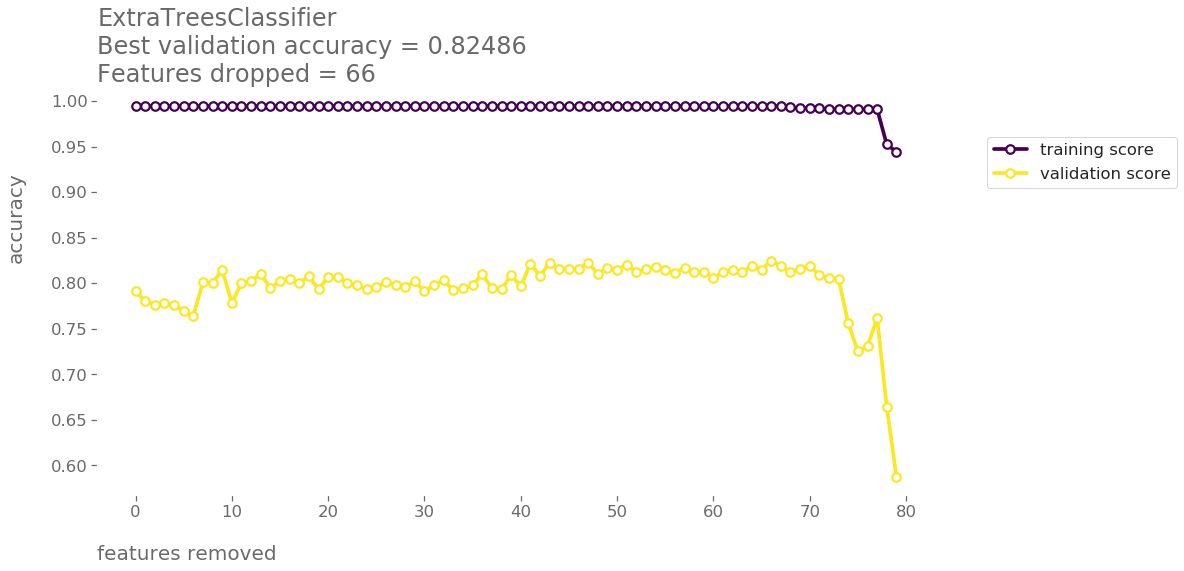

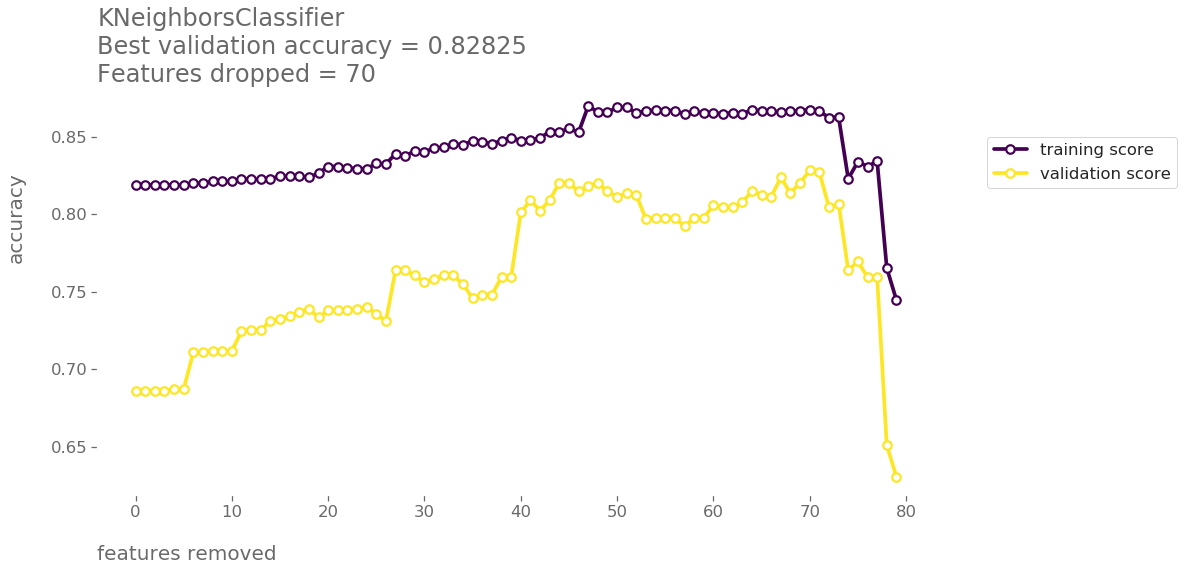

In [6]:
# visualize CV performance for diminishing feature set
fs.feature_selector_results_plot(
    scoring="accuracy",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
#     cv_summary= pd.read_csv("cv_summary_2001291517.csv", index_col=0),
#     feature_selector_summary=pd.read_csv("feature_selection_summary_2001291333.csv", index_col=0),
    title_scale=0.8,
)

In [7]:
cross_val_features_df = fs.create_cross_val_features_df(
    scoring="accuracy",
    cv_summary=cv_summary,
    feature_selector_summary=feature_selector_summary,
#     cv_summary= pd.read_csv("cv_summary_2001291517.csv", index_col=0),
#     feature_selector_summary=pd.read_csv("feature_selection_summary_2001291333.csv", index_col=0),
)

In [8]:
cross_val_feature_dict = fs.create_cross_val_features_dict(
    cross_val_features_df=cross_val_features_df
)

# Modeling

<a id = 'Modeling'></a>

## Data preparation

<a id = 'Data-preparation-1'></a>

In [3]:
#################################################################################
# import training data
df_train, df_valid = data.titanic()

# Load training data into mlmachine
ordinal_encodings = {
        "Pclass": [1, 2, 3], # Pclass
    }

train = mlm.Machine(
    data=df_train,
    target="Survived",
    remove_features=["PassengerId", "Ticket"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Cabin","Embarked","Name"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = ordinal_encodings,
    target_type="category",
)

# import validation data
valid = mlm.Machine(
    data=df_valid,
    remove_features=["PassengerId", "Ticket"],
    identify_as_continuous=["Age","Fare"],
    identify_as_count=["Parch","SibSp"],
    identify_as_nominal=["Cabin","Embarked","Name"],
    identify_as_ordinal=["Pclass"],
    ordinal_encodings = ordinal_encodings,
)

#################################################################################
# impute pipeline
impute_pipe = PandasFeatureUnion([
    ("age", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Age","Pclass"]),
        ContextImputer(null_col="Age", context_col="Pclass", strategy="mean")
    )),
    ("fare", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Fare","Pclass"]),
        ContextImputer(null_col="Fare", context_col="Pclass")
    )),
    ("embarked", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Embarked"]),
        PandasPipeline(impute.SimpleImputer(strategy="most_frequent"))
    )),
    ("cabin", pipeline.make_pipeline(
        DataFrameSelector(include_columns=["Cabin"]),
        PandasPipeline(impute.SimpleImputer(strategy="constant", fill_value="X"))
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_columns=["Age","Fare","Embarked","Cabin"])
    )),
])

train.data = impute_pipe.fit_transform(train.data)
valid.data = impute_pipe.transform(valid.data)

#################################################################################
# feature engineering - training

# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in train.data["Name"]]
train.data["Title"] = pd.Series(
    title,
    index=train.data.index,
    dtype="object",
)
train.data["Title"] = train.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
train.data["Title"] = train.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
train.data["Title"] = train.data["Title"].astype("category")

# distill cabin feature
train.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in train.data["Cabin"]],
    index=train.data.index,
    dtype="category",
)

# family size features
train.data["FamilySize"] = pd.to_numeric(train.data["SibSp"]) + pd.to_numeric(train.data["Parch"]) + 1

#################################################################################
# feature engineering - validation

# parse titles to learn gender, and identify rare titles which may convey status
title = [i.split(",")[1].split(".")[0].strip() for i in valid.data["Name"]]
valid.data["Title"] = pd.Series(
    title,
    index=valid.data.index,
    dtype="object"
)
valid.data["Title"] = valid.data["Title"].replace(
    [
        "Lady",
        "the Countess",
        "Countess",
        "Capt",
        "Col",
        "Don",
        "Dr",
        "Major",
        "Rev",
        "Sir",
        "Jonkheer",
        "Dona",
    ],
    "Rare",
)
valid.data["Title"] = valid.data["Title"].map(
    {"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3}
)
valid.data["Title"] = valid.data["Title"].astype("category")

# distill cabin feature
valid.data["CabinQuarter"] = pd.Series(
    [i[0] if not pd.isnull(i) else "X" for i in valid.data["Cabin"]],
    index=valid.data.index,
    dtype="category",
)

# additional features
valid.data["FamilySize"] = pd.to_numeric(valid.data["SibSp"]) + pd.to_numeric(valid.data["Parch"]) + 1

train.update_dtypes()
valid.update_dtypes()

#################################################################################
### feature transformation pipeline
# polynomial feature pipe
polynomial_pipe = PandasFeatureUnion([
    ("polynomial", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["continuous"]),
        PandasPipeline(preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["continuous"], exclude_columns=["Name","Cabin"]),
    )),
])

train.data = polynomial_pipe.fit_transform(train.data)
valid.data = polynomial_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

# encode & bin pipeline
encode_pipe = PandasFeatureUnion([
    ("nominal", pipeline.make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["nominal"]),
        PandasPipeline(preprocessing.OneHotEncoder(drop="first")),
    )),
    ("ordinal", pipeline.make_pipeline(
        DataFrameSelector(include_columns=list(ordinal_encodings.keys())),
        PandasPipeline(preprocessing.OrdinalEncoder(categories=list(ordinal_encodings.values()))),
    )),
    ("bin", pipeline.make_pipeline(
        DataFrameSelector(include_columns=train.data.mlm_dtypes["continuous"]),
        PandasPipeline(preprocessing.KBinsDiscretizer(encode="ordinal")),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_columns=train.data.mlm_dtypes["nominal"] + list(ordinal_encodings.keys())),
    )),
])

train.data = encode_pipe.fit_transform(train.data)
valid.data = encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

###
# complex encoding
target_encode_pipe = PandasFeatureUnion([
    ("target", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=ce.TargetEncoder,
        ),
    )),
    ("woe", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=ce.WOEEncoder,
        ),
    )),
    ("catboost", pipeline.make_pipeline(
        DataFrameSelector(include_mlm_dtypes=["category"]),
        KFoldSelectEncoder(
            target=train.target,
            cv=model_selection.KFold(n_splits=5, shuffle=False, random_state=0),
            encoder=ce.CatBoostEncoder,
        ),
    )),
    ("diff", pipeline.make_pipeline(
        DataFrameSelector(exclude_mlm_dtypes=["category"]),
    )),
])

train.data = target_encode_pipe.fit_transform(train.data)
valid.data = target_encode_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

### scale features
scale_pipe = PandasFeatureUnion([
    ("scale", pipeline.make_pipeline(
        DataFrameSelector(),
        PandasPipeline(preprocessing.RobustScaler())
    )),
])

train.data = scale_pipe.fit_transform(train.data)
valid.data = scale_pipe.transform(valid.data)

train.update_dtypes()
valid.update_dtypes()

#################################################################################
# remove outliers
outliers = np.array([258, 305, 438, 679, 737, 745])
train.data = train.data.drop(outliers)
train.target = train.target.drop(index=outliers)

print('completed')

>>> category label encoding

	0 --> 0
	1 --> 1

1
completed


## Bayesian hyper-parameter optimization

<a id = 'Bayesian-hyper-parameter-optimization'></a>

In [9]:
# model/parameter space
all_space = {
    "lightgbm.LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None, "balanced"]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"])
        # ,'boosting_type': hp.choice('boosting_type'
        #                    ,[{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)}
        #                    ,{'boosting_type': 'goss', 'subsample': 1.0}])
        ,
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_samples": hp.uniform("min_child_samples", 20, 500),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "num_leaves": hp.uniform("num_leaves", 8, 150),
        "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.5),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.uniform("subsample_for_bin", 20000, 400000),
    },
#     "linear_model.LogisticRegression": {
#         "C": hp.loguniform("C", np.log(0.001), np.log(0.2)),
#         "penalty": hp.choice("penalty", ["l1", "l2"]),
#     },
    "xgboost.XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
        "gamma": hp.uniform("gamma", 0.0, 10),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_child_weight": hp.uniform("min_child_weight", 1, 20),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "subsample": hp.uniform("subsample", 0.3, 1),
    },
    "ensemble.RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "ensemble.GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "ensemble.AdaBoostClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.3),
        "algorithm": hp.choice("algorithm", ["SAMME", "SAMME.R"]),
    },
    "ensemble.ExtraTreesClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 10000, 1, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 20, dtype=int)),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
        "max_features": hp.choice("max_features", ["auto", "sqrt"]),
        "criterion": hp.choice("criterion", ["gini", "entropy"]),
    },
    "svm.SVC": {
        "C": hp.uniform("C", 0.001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovo", "ovr"]),
        "gamma": hp.uniform("gamma", 0.000000001, 5),
    },
    "neighbors.KNeighborsClassifier": {
        "algorithm": hp.choice("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "n_neighbors": hp.choice("n_neighbors", np.arange(1, 20, dtype=int)),
        "weights": hp.choice("weights", ["distance", "uniform"]),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=train.data,
    target=train.target,
    columns=cross_val_feature_dict,
    scoring="accuracy",
    n_folds=5,
    n_jobs=5,
    iters=1500,
    show_progressbar=True,
)

####################################################################################################

Tuning lightgbm.LGBMClassifier

100%|█████████████████████████████████████████| 1500/1500 [2:51:37<00:00,  6.86s/trial, best loss: 0.14237288135593218]
####################################################################################################

Tuning xgboost.XGBClassifier

100%|██████████████████████████████████████████| 1500/1500 [7:44:46<00:00, 18.59s/trial, best loss: 0.1457627118644067]
####################################################################################################

Tuning ensemble.RandomForestClassifier

 68%|██████████████████████████▌            | 1021/1500 [3:07:53<1:15:24,  9.45s/trial, best loss: 0.14802259887005653]

##### Model loss by iteration

In [ ]:
# read scores summary table
bayes_optim_summary = pd.read_csv("bayes_optimization_summary_accuracy_2001300226.csv", na_values="nan")

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.model_loss_plot(
        bayes_optim_summary=bayes_optim_summary,
        estimator=estimator
    )

##### Parameter selection by iteration

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary["estimator"]):
    train.model_param_plot(
        bayes_optim_summary=bayes_optim_summary,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
#         chart_scale=15,
        title_scale=1.2
    )

In [ ]:
sample_space = {
                'param': hp.uniform('param', np.log(0.4), np.log(0.6))
#     "": 0.000001 + hp.uniform("gamma", 0.000001, 10)
    #             'param2': hp.loguniform('param2', np.log(0.001), np.log(0.01))
}

train.sample_plot(sample_space, 1000)

In [ ]:
# pair-wise comparison
p = PrettierPlot(chart_scale=12)
p.pair_plot_custom(
    df=train.unpack_bayes_optim_summary(bayes_optim_summary, "lightgbm.LGBMClassifier"),
    columns=["colsample_bytree", "learning_rate", "iteration","iter_loss"],
    gradient_col="iteration",
    color=style.style_grey
)

## Model performance evaluation - standard models

<a id = 'Model-performance-evaluation-standard-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(bayes_optim_summary=bayes_optim_summary, num_models=1)
top_models

In [ ]:
# classification panel, single model
# estimator = "svm.SVC"; model_iter = 1224
# estimator = 'ensemble.GradientBoostingClassifier'; model_iter = 590
estimator = 'xgboost.XGBClassifier'; model_iter = 1256

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)

train.classification_panel(
    model=model,
    X_train=train.data,
    y_train=train.target,
    cm_labels=["Dies", "Survives"],
    n_folds=5,
    title_scale=0.9
)

In [ ]:
# create classification reports for training data
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model, X_train=train.data, y_train=train.target, cm_labels=['Dies', 'Survives'], n_folds=4
        )

## Model explanability

<a id = 'Feature-importance'></a>

In [ ]:
# 
# estimator = "ensemble.ExtraTreesClassifier"; model_iter = 145
# estimator = "svm.SVC"; model_iter = 135
estimator = "ensemble.GradientBoostingClassifier"; model_iter = 1385

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)
model.fit(train.data.values, train.target.values)

##### Permutation importance

In [ ]:
# permutation importance - how much does performance decrease when shuffling a certain feature?
perm = PermutationImportance(model.model, random_state=1).fit(train.data, train.target)
eli5.show_weights(perm, feature_names=train.data.columns.tolist())

##### SHAP values - training data

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in train.data.index[:5]:
    train.single_shap_viz_tree(obsIx=i, model=model, data=train.data, target=train.target)

###### Force plots - multiple observations

In [ ]:
# SHAP force plot a set of data
visual = train.multi_shap_viz_tree(obs_ixs=train.data.index, model=model, data=train.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = train.multi_shap_value_tree(
    obs_ixs=train.data.index, model=model, data=train.data
)

In [ ]:
# SHAP dependence plot grid
# grid_features = ["Pclass", "Age", "Fare", "SibSp","Parch"]
grid_features = ['Age*Fare','Title_2','Fare*FamilySize','Sex_male','Fare','Pclass','CabinQuarter_X']

train.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=train.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

train.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Fare",
    color_feature="Sex_male",
    feature_names=train.data.columns,
    dot_size=50,
    alpha=0.5,
    ax=ax
)


In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = train.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()
    
    train.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Fare",
        feature_names=feature_names,
        dot_size=50,
        alpha=0.5,
        ax=ax,
    )

###### Summary plots

In [ ]:
# SHAP summary plot
train.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=train.data.columns,
    )

##### SHAP values - validation data

###### Force plots - single observations

In [ ]:
# SHAP force plots for individual observations
for i in valid.data.index[:2]:
    valid.single_shap_viz_tree(obsIx=i, model=model, data=valid.data)

###### Force plots - multiple observations

In [ ]:
# SHAP force plot a set of data
visual = valid.multi_shap_viz_tree(obs_ixs=valid.data.index, model=model, data=valid.data)
visual

###### Dependence plots

In [ ]:
# generate SHAP values for set of observations
obs_data, _, obs_shap_values = valid.multi_shap_value_tree(
    obs_ixs=valid.data.index, model=model, data=valid.data
)

In [ ]:
# SHAP dependence plot grid
grid_features = ["Pclass", "Age", "Fare", "SibSp","Parch"]

valid.shap_dependence_grid(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    grid_features=grid_features,
    all_features=valid.data.columns,
    dot_size=35,
    alpha=0.5,
)

In [ ]:
# single SHAP dependence plot
p = PrettierPlot()
ax = p.make_canvas()

valid.shap_dependence_plot(
    obs_data=obs_data,
    obs_shap_values=obs_shap_values,
    scatter_feature="Age",
    color_feature="Parch",
    feature_names=valid.data.columns,
    dot_size=50,
    alpha=0.5,
    ax=ax
)


In [ ]:
# SHAP dependence plots for all feature relative to an interaction feature
feature_names = valid.data.columns.tolist()
top_shap = np.argsort(-np.sum(np.abs(obs_shap_values), 0))

for top_ix in top_shap:
    p = PrettierPlot()
    ax = p.make_canvas()
    
    valid.shap_dependence_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        scatter_feature=feature_names[top_ix],
        color_feature="Age",
        feature_names=feature_names,
        dot_size=50,
        alpha=0.5,
        ax=ax,
    )

###### Summary plots

In [ ]:
# SHAP summary plot
valid.shap_summary_plot(
        obs_data=obs_data,
        obs_shap_values=obs_shap_values,
        feature_names=valid.data.columns,
    )

## Submission - standard models

<a id = 'Submission-standard-models'></a>

In [ ]:
{'lightgbm.LGBMClassifier': [778],
 'linear_model.LogisticRegression': [730],
 'xgboost.XGBClassifier': [371],
 'ensemble.RandomForestClassifier': [712],
 'ensemble.GradientBoostingClassifier': [965],
 'ensemble.AdaBoostClassifier': [512],
 'ensemble.ExtraTreesClassifier': [244],
 'svm.SVC': [551],
 'neighbors.KNeighborsClassifier': [576]}

In [ ]:
## standard model fit and predict
# select estimator and iteration
# estimator = "lightgbm.LGBMClassifier"; model_iter = 778  #147 survived, 0.775
# estimator = "xgboost.XGBClassifier"; model_iter = 371  #142 survived, 0.765
# estimator = "ensemble.RandomForestClassifier"; model_iter = 712  #144 survived, 0.7655
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 965  #144 survived, 0.7561
estimator = "svm.SVC"; model_iter = 551  # survived, 

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary, estimator=estimator, model_iter=model_iter
)
model.fit(train.data.values, train.target.values)

# fit model and make predictions
y_pred = model.predict(valid.data.values)
print(sum(y_pred))

In [ ]:
# generate prediction submission file
submit = pd.DataFrame({"PassengerId": df_valid.PassengerId, "Survived": y_pred})
submit.to_csv("submission.csv", index=False)

# Stacking

<a id = 'Stacking'></a>

## Primary models

<a id = 'Primary-models'></a>

In [ ]:
{'lightgbm.LGBMClassifier': [778],
 'linear_model.LogisticRegression': [730],
 'xgboost.XGBClassifier': [371],
 'ensemble.RandomForestClassifier': [712],
 'ensemble.GradientBoostingClassifier': [965],
 'ensemble.AdaBoostClassifier': [512],
 'ensemble.ExtraTreesClassifier': [244],
 'svm.SVC': [551],
 'neighbors.KNeighborsClassifier': [576]}

In [ ]:
lgb = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="lightgbm.LGBMClassifier", model_iter=778)
lr = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="linear_model.LogisticRegression", model_iter=730)
xgb = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="xgboost.XGBClassifier", model_iter=371)
rf = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.RandomForestClassifier", model_iter=712)
gb = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.GradientBoostingClassifier", model_iter=965)
ada = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.AdaBoostClassifier", model_iter=512)
ext = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="ensemble.ExtraTreesClassifier", model_iter=244)
svc = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="svm.SVC", model_iter=551)
kn = train.BayesOptimModelBuilder(bayes_optim_summary=bayes_optim_summary, estimator="neighbors.KNeighborsClassifier", model_iter=576)

In [ ]:
from vecstack import StackingTransformer
import sklearn.metrics as metrics
# Get your data

# Initialize 1st level estimators
estimators = [('lgb', lgb.model),
              ('lr',lr.model),
              ('xgb',xgb.model),
              ('rf',rf.model),
              ('gb',gb.model),
              ('ada',ada.model),
              ('ext',ext.model),
              ('svc',svc.model),
              ('kn',kn.model),
             ]
              
# Initialize StackingTransformer
stack = StackingTransformer(
    estimators,
    regression=False,
    metric=metrics.accuracy_score,
    verbose=2
)

# Fit
stack = stack.fit(train.data, train.target)

# Get your stacked features
oof_train = stack.transform(train.data)
oof_valid = stack.transform(valid.data)

# Use 2nd level estimator with stacked features

In [ ]:
# get out-of-fold predictions
oof_train, oof_valid, columns = train.model_stacker(
    models=top_models,
    bayes_optim_summary=bayes_optim_summary,
    X_train=train.data.values,
    y_train=train.target.values,
    X_valid=valid.data.values,
    n_folds=10,
    n_jobs=10,
)

In [ ]:
# view correlations of predictions
p = PrettierPlot()
ax = p.make_canvas()
p.corr_heatmap(
    df=pd.DataFrame(oof_train, columns=columns), annot=True, ax=ax, vmin=0
)
plt.show()

## Meta model

<a id = 'Meta-model'></a>

In [ ]:
# parameter space
all_space = {
    "lightgbm.LGBMClassifier": {
        "class_weight": hp.choice("class_weight", [None]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "boosting_type": hp.choice("boosting_type", ["dart"]),
        "subsample": hp.uniform("subsample", 0.5, 1),
        "learning_rate": hp.uniform("learning_rate", 0.15, 0.25),
        "max_depth": hp.choice("max_depth", np.arange(4, 20, dtype=int)),
        "min_child_samples": hp.quniform("min_child_samples", 50, 150, 5),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "num_leaves": hp.quniform("num_leaves", 30, 70, 1),
        "reg_alpha": hp.uniform("reg_alpha", 0.75, 1.25),
        "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
        "subsample_for_bin": hp.quniform("subsample_for_bin", 100000, 350000, 20000),
    },
    "xgboost.XGBClassifier": {
        "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.7),
        "gamma": hp.quniform("gamma", 0.0, 10, 0.05),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.01),
        "max_depth": hp.choice("max_depth", np.arange(2, 15, dtype=int)),
        "min_child_weight": hp.quniform("min_child_weight", 2.5, 7.5, 1),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "subsample": hp.uniform("subsample", 0.4, 0.7),
    },
    "ensemble.RandomForestClassifier": {
        "bootstrap": hp.choice("bootstrap", [True, False]),
        "max_depth": hp.choice("max_depth", np.arange(2, 10, dtype=int)),
        "n_estimators": hp.choice("n_estimators", np.arange(100, 8000, 10, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(15, 25, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 20, dtype=int)),
    },
    "ensemble.GradientBoostingClassifier": {
        "n_estimators": hp.choice("n_estimators", np.arange(100, 4000, 10, dtype=int)),
        "max_depth": hp.choice("max_depth", np.arange(2, 11, dtype=int)),
        "max_features": hp.choice("max_features", ["sqrt"]),
        "learning_rate": hp.quniform("learning_rate", 0.01, 0.09, 0.01),
        "loss": hp.choice("loss", ["deviance", "exponential"]),
        "min_samples_split": hp.choice(
            "min_samples_split", np.arange(2, 40, dtype=int)
        ),
        "min_samples_leaf": hp.choice("min_samples_leaf", np.arange(2, 40, dtype=int)),
    },
    "svm.SVC": {
        "C": hp.uniform("C", 0.00000001, 15),
        "decision_function_shape": hp.choice("decision_function_shape", ["ovr", "ovo"]),
        "gamma": hp.uniform("gamma", 0.00000001, 1.5),
    },
}

In [ ]:
# execute bayesian optimization grid search
train.exec_bayes_optim_search(
    all_space=all_space,
    data=oof_train,
    target=train.target,
    scoring="accuracy",
    n_folds=8,
    n_jobs=8,
    iters=1000,
    verbose=0,
)

In [ ]:
df = pd.DataFrame()

In [ ]:
type(df)

In [ ]:
# read scores summary table
bayes_optim_summary_meta = pd.read_csv("{}_hyperopt_meta_{}.csv".format(rundate, analysis))
bayes_optim_summary_meta[:5]

In [ ]:
# model loss plot
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.model_loss_plot(bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator)

In [ ]:
# estimator parameter plots
for estimator in np.unique(bayes_optim_summary_meta["estimator"]):
    train.modelParamPlot(
        bayes_optim_summary=bayes_optim_summary_meta,
        estimator=estimator,
        all_space=all_space,
        n_iter=100,
        chart_scale=15,
    )

## Model performance evaluation - stacked models

<a id = 'Model-performance-evaluation-stacked-models'></a>

In [ ]:
top_models = train.top_bayes_optim_models(
    bayes_optim_summary=bayes_optim_summary_meta, num_models=1
)
top_models

In [ ]:
# classification panel, single model
estimator = "svm.SVC"; model_iter = 135
# estimator = 'ensemble.GradientBoostingClassifier'; model_iter = 590
# estimator = 'xgboost.XGBClassifier'; model_iter = 380

model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)

train.classification_panel(
    model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
)

In [ ]:
# create classification reports for training data
for estimator, model_iters in top_models.items():
    for model_iter in model_iters:
        model = train.BayesOptimModelBuilder(
            bayes_optim_summary=bayes_optim_summary_meta,
            estimator=estimator,
            model_iter=model_iter,
        )
        train.classification_panel(
            model=model, X_train=oof_train, y_train=train.target, labels=[0, 1], n_folds=4
        )

## Submission - stacked models

<a id = 'Submission-stacked-models'></a>

In [ ]:
# best second level learning model
# estimator = "lightgbm.LGBMClassifier"; model_iter = 876 #0.75119
# estimator = "xgboost.XGBClassifier"; model_iter = 821, #0.779
# estimator = "ensemble.RandomForestClassifier"; model_iter = 82 
# estimator = "ensemble.GradientBoostingClassifier"; model_iter = 673 #0.77511
estimator = "svm.SVC"; model_iter = 538 # 0.77511

# extract params and instantiate model
model = train.BayesOptimModelBuilder(
    bayes_optim_summary=bayes_optim_summary_meta, estimator=estimator, model_iter=model_iter
)

model.fit(oof_train, train.target.values)
y_pred = model.predict(oof_valid)
print(sum(y_pred))

In [ ]:
# generate prediction submission file
submit = pd.DataFrame({"PassengerId": df_valid.PassengerId, "Survived": y_pred})
submit.to_csv("submission.csv", index=False)